# Unsupervised Customer Clustering

First, the necessary libraries are imported:

In [2]:
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

#clustering 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

The data is imported and unccessary columns are dropped:

In [3]:
customer_model = pd.read_csv('customer_model.csv')

In [4]:
customer_model.drop(columns=['Unnamed: 0','Customer ID'],inplace=True)

# KMeans Clustering

The clustering values are identified as the entire dataset:

In [5]:
X_clustering = customer_model.iloc[:,1:]

In [6]:
X_clustering_cols = X_clustering.columns

The data is scaled prior to clustering:

In [7]:
my_scaler = StandardScaler()
X = my_scaler.fit_transform(X_clustering)

A PCA model is fit to see the amount of variance contained in a given number of features:

In [8]:
PCA_model = PCA().fit(X)

Text(0, 0.5, 'cumulative explained variance')

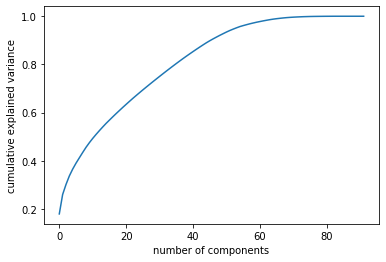

In [9]:
plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

According to the plot, approximately 50 components can explain 90% of the data. The first three components explain around 30% of the variance.

The analysis begins by using a dimensionality reduction to cluster on 50 components:

In [10]:
my_pca = PCA(n_components=50)
my_pca.fit(X)
X = my_pca.transform(X)

The model is run with an initial 6 clusters and the resuts are plotted using a TSNE reduction to 2 components to visualize the clusters.

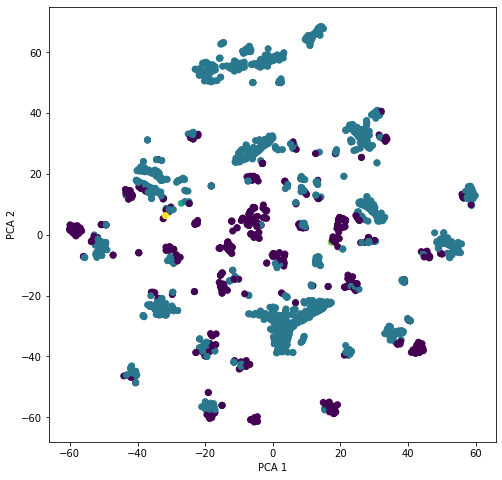

In [11]:
k_means_modelx = KMeans(n_clusters = 6)
k_means_modelx.fit(X)
pred_labelsx = k_means_modelx.labels_


my_pcax = TSNE(n_components=2)
X = my_pcax.fit_transform(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0],X[:,1],c=pred_labelsx)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()

The results are showing a poor clustering - a different approach is then taken.

# Clustering on RFM Values

The Recency, Frequency, and Monetary (RFM) value of transactions are then used to cluster:

In [12]:
RFM_model = customer_model[['revenue','frequency','recency']]

To ensure the monetary value doesn't dominate the clustering, each is assignned a value based on the quartile it falls within (on a scale of 1 to 4).

In [13]:
RFM_model['revenue'] = pd.qcut(customer_model['revenue'], 4, labels=[1,2,3,4])
RFM_model['frequency'] = pd.qcut(customer_model['frequency'], q=[0, .5, .67, .84, 1], labels=[1,2,3,4])
RFM_model['recency'] = pd.qcut(customer_model['recency'], 4, labels=[4,3,2,1])

C:\Users\rache\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\rache\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\rache\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

The intertia is plotted to determine the number of clusters based on the elbow method.

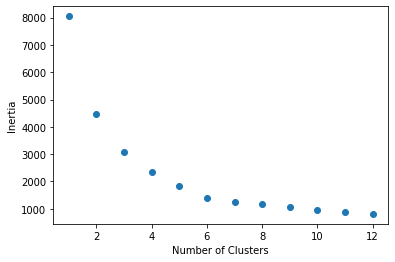

In [14]:
k_range = np.arange(1,13)

inertia_list = []

for k in k_range :
    
    k_means_model = KMeans(n_clusters = k)
    k_means_model.fit(RFM_model)
    inertia_list.append(k_means_model.inertia_)
    
plt.figure()
plt.scatter(k_range,inertia_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

According to the plot, 6 clusters are selected.

The RFM model is then clustered with 6 clusters.

In [15]:
k_means_model = KMeans(n_clusters = 6)
k_means_model.fit(RFM_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Results are moved to a dataframe to view:

In [16]:
k_means_results = pd.DataFrame(data = k_means_model.cluster_centers_.tolist(), columns=['revenue','frequency','recency'])

In [17]:
k_means_results

revenue  frequency   recency
0  3.337423   3.411043  1.546012
1  1.532500   1.077500  3.362500
2  1.451817   1.067930  1.480253
3  3.408759   1.208029  3.481752
4  3.607595   3.577215  3.663291
5  3.340741   1.185185  1.518519

Descriptions of clusters are generated based on whether the values are above or below the center value.

In [18]:
k_means_results['R'] = k_means_results['recency'].apply(lambda x: 1 if (x > 2) else 0).values
k_means_results['F'] = k_means_results['frequency'].apply(lambda x: 1 if (x > 2) else 0).values
k_means_results['M'] = k_means_results['revenue'].apply(lambda x: 1 if (x > 2) else 0).values

In [19]:
RFM_groups = []

for i in range(0,6):
    if k_means_results.loc[i,'M'] == 1:
        RFM_groups.append('High Value/')
    else:
        RFM_groups.append('Low Value/')
    if k_means_results.loc[i,'F'] == 1:
        RFM_groups[i] += ('Regular/')
    else:
        RFM_groups[i] += ('One Time/')
    if k_means_results.loc[i, 'R'] == 1:
        RFM_groups[i] += ('Current')
    else:
        RFM_groups[i] += ('Churned')
        

In [20]:
k_means_results['Customer Group'] = RFM_groups

Cutstomer groups are then shown on a heatmap.

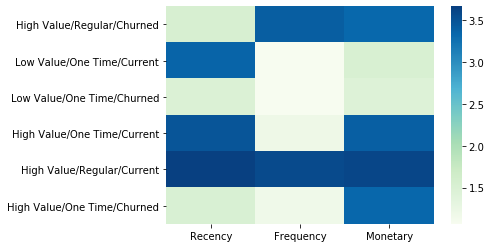

In [21]:
sns.heatmap(data=k_means_results[['recency','frequency','revenue']],cmap='GnBu',xticklabels = ['Recency','Frequency','Monetary'],yticklabels=k_means_results['Customer Group'])

# Marketing Strategies:


Marketing strategies are developed based on customer groups.

In [22]:
pred_labels = k_means_model.labels_

In [23]:
k_means_results

revenue  frequency   recency  R  F  M               Customer Group
0  3.337423   3.411043  1.546012  0  1  1   High Value/Regular/Churned
1  1.532500   1.077500  3.362500  1  0  0   Low Value/One Time/Current
2  1.451817   1.067930  1.480253  0  0  0   Low Value/One Time/Churned
3  3.408759   1.208029  3.481752  1  0  1  High Value/One Time/Current
4  3.607595   3.577215  3.663291  1  1  1   High Value/Regular/Current
5  3.340741   1.185185  1.518519  0  0  1  High Value/One Time/Churned

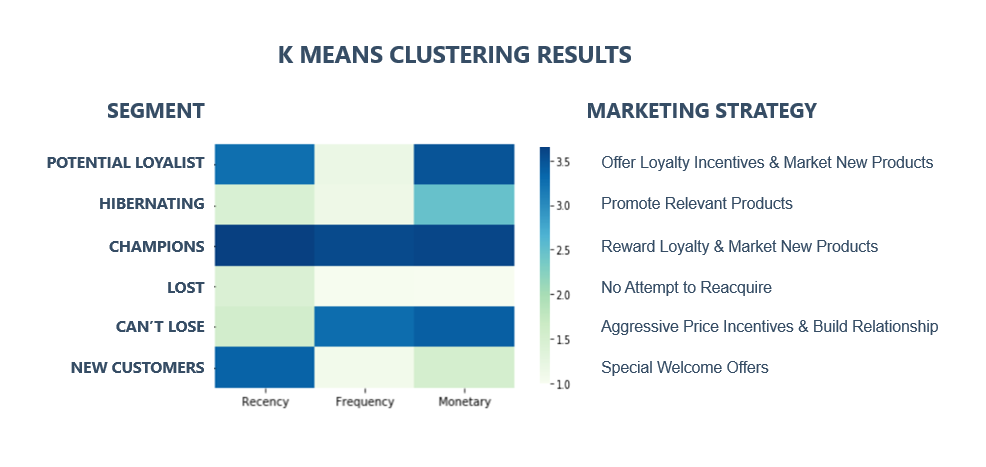

In [24]:
customer_model_with_groups = customer_model
customer_model_with_groups['Label'] = pred_labels

In [25]:
customer_model_with_groups['Customer Group'] = ''

Customers (with all features) are assigned to each group:

In [26]:
for i in range(0,2135):
    label = customer_model_with_groups.iloc[i,-2]
    group = k_means_results.iloc[label,6]
    customer_model_with_groups.iloc[i,-1] = group

In [27]:
customer_model_with_groups.rename(columns={'recency':'Recency','revenue':'Revenue','frequency':'Frequency'},inplace=True)

Customer groups are then plotted on recency and revenue of purchases:

In [28]:
fig = px.scatter(customer_model_with_groups,
                 x='Recency', 
                 y='Revenue',
                 color='Customer Group'
                )
fig.show()

To improve the visualizations, another TSNE reduction is performed to view all features on a 2 dimensional space.

In [29]:
my_pca = TSNE(n_components=2)
X = my_pca.fit_transform(X_clustering)
df_X = pd.DataFrame(data = X.tolist(), columns=['TSNE Component 1','TSNE Component 2'])
df_X['Customer Group'] = customer_model_with_groups['Customer Group']

In [30]:
fig = px.scatter(df_X,
                 'TSNE Component 1',
                 'TSNE Component 2',
                 color='Customer Group')
fig.show()

The TSNE reduction plot confirms that the clusters (developed on RFM values only) actually have shared characteristics across the dataset.

# Cluster Intepretations

The shared characteristics are then interpreted to identify features regarding churned customers.

In [31]:
X_clustering['cluster_RFM'] = pred_labels

In [32]:
RFM_k_means_cluster_results = pd.DataFrame(columns = X_clustering.columns.to_list(),index=[0,1,2,3,4,5])

Mean values of each feature are calculated based on the different customer groups

In [33]:
for i in range(0,6):
    RFM_k_means_cluster_results.loc[i] = list(X_clustering[X_clustering['cluster_RFM']==i].mean())
        

In [34]:
cols = RFM_k_means_cluster_results.columns.to_list()
RFM_k_means_cluster_results[cols] = RFM_k_means_cluster_results[cols].apply(pd.to_numeric, errors='coerce', axis=1)

Data is scaled and plotted on a heatmap to view the various mean feature values in each of the 6 customer groups:

In [35]:
my_scaler = StandardScaler()
RFM_k_means_cluster_results_scaled = my_scaler.fit_transform(RFM_k_means_cluster_results)

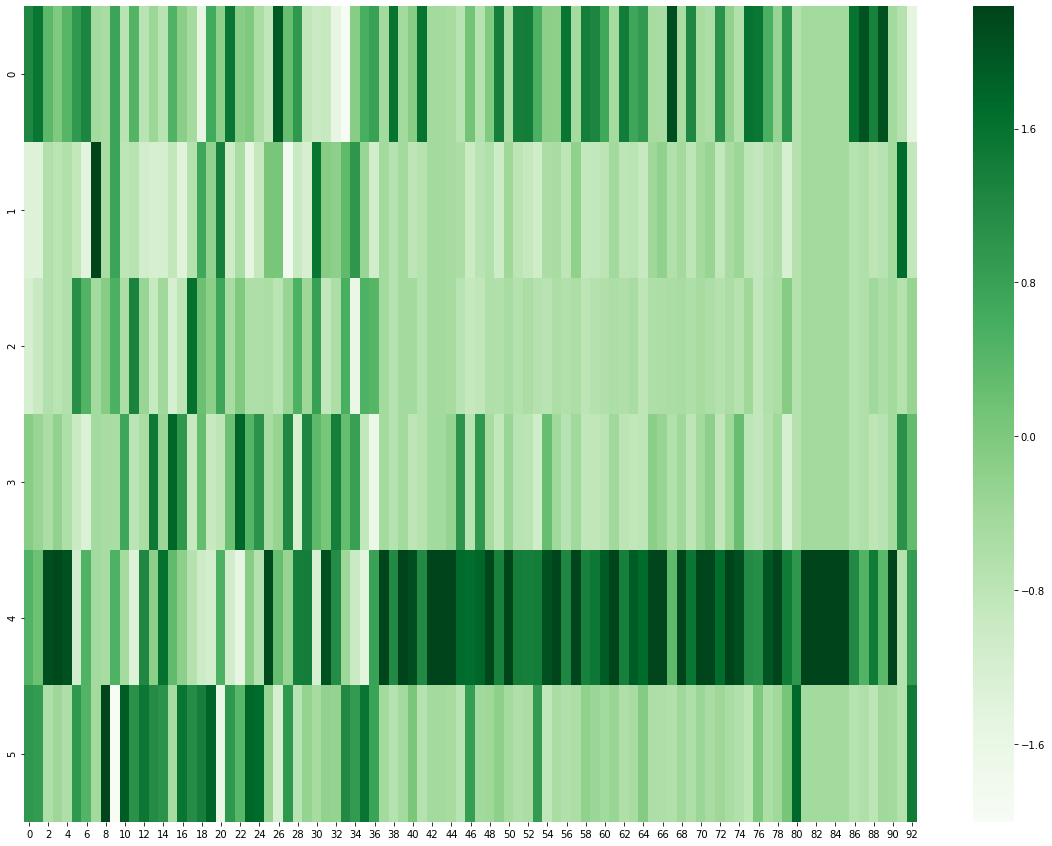

In [36]:
plt.subplots(figsize=(20,15))
sns.heatmap(data=RFM_k_means_cluster_results_scaled,cmap='Greens')

In order to derive some meaning from these clusters, a heatmap is applied to a dataframe which contains the mean feature values for each customer group

In [37]:
RFM_k_means_cluster_results['Customer Group'] = k_means_results['Customer Group']

In [38]:
RFM_k_means_cluster_results.set_index('Customer Group',inplace=True)

In [39]:
cm = sns.light_palette("green", as_cmap=True)

cluster_char = RFM_k_means_cluster_results.style.background_gradient(cmap=cm)
cluster_char

# Assessing Differences in the Cluster Averages

## What features are characteristic of a good churned customer vs a good current customer?

Top churned vs top current customers are then compared.

In [40]:
RFM_k_means_cluster_results

size  corporation       jobs       revenue  \
Customer Group                                                                
High Value/Regular/Churned   0.331288     0.337423  11.638037   5706.460859   
Low Value/One Time/Current   0.127500     0.115000   1.660000    315.528275   
Low Value/One Time/Churned   0.139021     0.143760   1.559242    277.108025   
High Value/One Time/Current  0.226277     0.193431   2.408759   4314.500657   
High Value/Regular/Current   0.270886     0.230380  28.729114  21728.008987   
High Value/One Time/Churned  0.311111     0.285185   1.996296   3249.070963   

                             frequency      recency     cust_age  \
Customer Group                                                     
High Value/Regular/Churned    9.963190  2375.184049  3377.104294   
Low Value/One Time/Current    1.357500   651.700000   860.932500   
Low Value/One Time/Churned    1.311216  2525.703002  2625.728278   
High Value/One Time/Current   1.711679   564.080292   981.182482   
High Value/Regular/Current   23.192405   401.078481  2639.164557   
High Value/One Time/Churned   1.670370  2387.981481  2613.422222   

                             manufacturer_loc_Admin  \
Customer Group                                        
High Value/Regular/Churned                   0.0000   
Low Value/One Time/Current                   0.0025   
Low Value/One Time/Churned                   0.0000   
High Value/One Time/Current                  0.0000   
High Value/Regular/Current                   0.0000   
High Value/One Time/Churned                  0.0000   

                             manufacturer_loc_Industrial Fabric  \
Customer Group                                                    
High Value/Regular/Churned                             0.000000   
Low Value/One Time/Current                             0.000000   
Low Value/One Time/Churned                             0.004739   
High Value/One Time/Current                            0.000000   
High Value/Regular/Current                             0.000000   
High Value/One Time/Churned                            0.029630   

                             manufacturer_loc_Squamish  ...  \
Customer Group                                          ...   
High Value/Regular/Churned                    0.969325  ...   
Low Value/One Time/Current                    0.970000  ...   
Low Value/One Time/Churned                    0.954186  ...   
High Value/One Time/Current                   0.875912  ...   
High Value/Regular/Current                    0.951899  ...   
High Value/One Time/Churned                   0.770370  ...   

                             product_5210 · Metal Work - Materials  \
Customer Group                                                       
High Value/Regular/Churned                                0.000000   
Low Value/One Time/Current                                0.000000   
Low Value/One Time/Churned                                0.000000   
High Value/One Time/Current                               0.000000   
High Value/Regular/Current                                0.002532   
High Value/One Time/Churned                               0.000000   

                             product_5310 · Substrates  \
Customer Group                                           
High Value/Regular/Churned                    0.000000   
Low Value/One Time/Current                    0.000000   
Low Value/One Time/Churned                    0.000000   
High Value/One Time/Current                   0.000000   
High Value/Regular/Current                    0.002532   
High Value/One Time/Churned                   0.000000   

                             product_5325 · Printable Banner  \
Customer Group                                                 
High Value/Regular/Churned                          0.000000   
Low Value/One Time/Current                          0.000000   
Low Value/One Time/Churned                          0.000000   
High Value/One Time/Curren

Churned vs current customer groups are extracted

In [41]:
churned_vs_current = RFM_k_means_cluster_results[(RFM_k_means_cluster_results.index =='High Value/Regular/Churned') | (RFM_k_means_cluster_results.index=='High Value/Regular/Current')].T

Percentage difference is then calculated and displayed:

In [42]:
churned_vs_current['Percent Diff'] = (churned_vs_current.iloc[:,0] - churned_vs_current.iloc[:,1])/((churned_vs_current.iloc[:,0]+churned_vs_current.iloc[:,1])/2)*100

The data is sorted by percent difference between top current and top churned

In [43]:
churned_vs_current.iloc[0:6,:].sort_values(by='Percent Diff',ascending=False)

Customer Group  High Value/Regular/Churned  High Value/Regular/Current  \
recency                        2375.184049                  401.078481   
corporation                       0.337423                    0.230380   
size                              0.331288                    0.270886   
frequency                         9.963190                   23.192405   
jobs                             11.638037                   28.729114   
revenue                        5706.460859                21728.008987   

Customer Group  Percent Diff  
recency           142.213177  
corporation        37.704470  
size               20.061386  
frequency         -79.800799  
jobs              -84.678144  
revenue          -116.798671

Next, the various attributes are compared between current and churned.

**Regions**

In [45]:
churned_vs_current.iloc[11:25,:].sort_values(by='Percent Diff',ascending=False)

Customer Group        High Value/Regular/Churned  High Value/Regular/Current  \
region_surrey                           0.110429                    0.015190   
region_prairies_can                     0.012270                    0.002532   
region_bc_island                        0.012270                    0.005063   
region_us                               0.006135                    0.002532   
region_bc_west                          0.006135                    0.005063   
region_bc_northshore                    0.067485                    0.063291   
region_bc_south                         0.018405                    0.017722   
region_whistler                         0.073620                    0.070886   
region_vancouver                        0.141104                    0.136709   
region_bc_lower_west                    0.018405                    0.020253   
region_squamish                         0.496933                    0.594937   
region_bc_lower_main                    0.024540                    0.035443   
region_bc_north                         0.012270                    0.025316   
region_central_can                      0.000000                    0.005063   

Customer Group        Percent Diff  
region_surrey           151.632047  
region_prairies_can     131.584470  
region_bc_island         83.154122  
region_us                83.154122  
region_bc_west           19.140083  
region_bc_northshore      6.413302  
region_bc_south           3.783319  
region_whistler           3.783319  
region_vancouver          3.164309  
region_bc_lower_west     -9.562073  
region_squamish         -17.951636  
region_bc_lower_main    -36.354221  
region_bc_north         -69.421488  
region_central_can     -200.000000

**Industries**

In [46]:
churned_vs_current.iloc[25:37,:].sort_values(by='Percent Diff',ascending=False)

Customer Group                          High Value/Regular/Churned  \
industry_retail                                           0.104294   
industry_individual                                       0.049080   
industry_construction_home_improvement                    0.319018   
industry_real_estate                                      0.061350   
industry_food                                             0.110429   
industry_tourism_film_entertainment                       0.104294   
industry_government_nfp                                   0.098160   
industry_manufacturing_distribution                       0.012270   
industry_health_fitness                                   0.055215   
industry_professional_services                            0.030675   
industry_automotive_transportation                        0.036810   
industry_logging_mining_utilities                         0.018405   

Customer Group                          High Value/Regular/Current  \
industry_retail                                           0.060759   
industry_individual                                       0.032911   
industry_construction_home_improvement                    0.243038   
industry_real_estate                                      0.050633   
industry_food                                             0.093671   
industry_tourism_film_entertainment                       0.103797   
industry_government_nfp                                   0.106329   
industry_manufacturing_distribution                       0.017722   
industry_health_fitness                                   0.086076   
industry_professional_services                            0.058228   
industry_automotive_transportation                        0.096203   
industry_logging_mining_utilities                         0.050633   

Customer Group                          Percent Diff  
industry_retail                            52.752423  
industry_individual                        39.439288  
industry_construction_home_improvement     27.036587  
industry_real_estate                       19.140083  
industry_food                              16.421886  
industry_tourism_film_entertainment         0.477683  
industry_government_nfp                    -7.990278  
industry_manufacturing_distribution       -36.354221  
industry_health_fitness                   -43.684731  
industry_professional_services            -61.984626  
industry_automotive_transportation        -89.304064  
industry_logging_mining_utilities         -93.363330

**Products**

In [47]:
churned_vs_current.iloc[37:-1,:].sort_values(by='Percent Diff',ascending=False)

Customer Group                                  High Value/Regular/Churned  \
product_4540 · Printing - Stationary                              0.042945   
product_5830 · Shipping Costs                                     0.478528   
product_5760 · Sign Material - Coroplast                          0.006135   
product_4800 · Promotional Items                                  0.018405   
product_1220 · Fabric Inventory                                   0.006135   
product_4900 · Income - Other                                     0.030675   
product_1257 · Substrates                                         0.012270   
product_5500 · Awning Fabrics                                     0.006135   
product_4230 · Signs - Frames & Sandwich Board                    0.343558   
product_4090 · Window Graphics                                    0.104294   
product_4280 · Signs - Coroplast                                  4.717791   
product_4250 · Signs - Routing                                    0.196319   
product_4115 · Banners                                            0.711656   
product_4100 · Large Format Printing                              2.730061   
product_5782 · Sign Material  - Others                            0.042945   
product_4260 · Signs - Electric                                   0.834356   
product_4580 · Design Work - Other                                1.846626   
product_5020 · Pressure Sensitive Vinyl                           0.006135   
product_4700 · Service & Maintenance                              1.466258   
product_4290 · Signage parts                                      0.104294   
product_4120 · Disbursement Recovery                              0.018405   
product_4285 · Vehicle Graphics                                   0.766871   
product_4270 · Signs - Non Coroplast                              1.472393   
product_4950 · Shipping Revenue                                   0.134969   
product_4040 · Awnings & Structures                               0.257669   
product_4150 · Window Graphics                                    0.049080   
product_1256 · Vinyl-Pressure Sensitive Lamin                     0.006135   
product_4080 · Industrial Fabric Goods                            0.220859   
product_4200 · Signage                                            2.601227   
product_4720 · Shippin & Recoverable Expenses                     0.055215   
product_4955 · Donation of Services                               0.006135   
product_4300 · Vehicle Graphics                                   0.104294   
product_4275 · Banners                                            0.042945   
product_4050 · Awnings & Structures                               0.042945   
product_4750 · Installation Income                                0.104294   
product_4250 · Decals and Stickers                                0.159509   
product_4400 · Printing & Design                                  0.202454   
product_4100 · Industrial Fabric Goods                            0.012270   
product_5310 · Substrates                                         0.000000   
product_5210 · Metal Work - Materials                             0.000000   
product_5065 · Over Laminates                                     0.000000   
product_5325 · Printable Banner                                   0.000000   
product_5050 · Cut Vinyl                                          0.000000   
product_1210 · Metal                                              0.000000   
product_5040 · Fabrics                                            0.000000   
product_4700 · Promotion & Donation of Service                    0.000000   
product_4600 · Tarps, Tent Frames etc                             0.000000   
product_4550 · Service & Maintenance                              0.000000   
product_4000 · Revenue                                            0.000000   
product_2018 · Deferred Income                                    0.000000   
product_1420 · Substra

Key Differences:
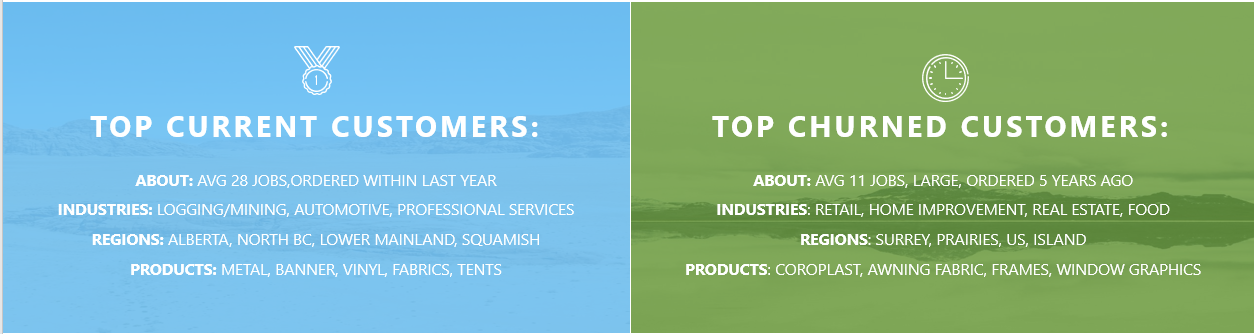